# **Assignment 1**
# **Derivation of solar differential rotation from measuring sunspot positions**
### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

**The objective of this assignment is to learn how to derive the angular velocity of solar rotation from following sunspots in white-light solar images obtained in the Kanzelhöhe Observatory in Austria. The Sun is known to show a differential rotation, i.e. the equator rotates faster than poles. Differential rotation is a key process for the solar dynamo, i.e. reprocessing the solar magnetic field in the course of the 11-year solar cycle. In addition, the knowledge of solar rotation allows the prediction of the recurrence of large groups of sunspots on the Earth-facing hemisphere causing space–weather effects on Earth.**

In [ ]:
# Firstly, we install SunPy package
!pip install git+https://github.com/sunpy/sunpy

In [ ]:
# After that, we import several libraries which will be used during the assignment implementation 
from astropy.io import fits
from astropy import units as u

In [ ]:
import sunpy
import sunpy.map

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage 
import numpy as np
import math
from google.colab import files
from scipy.stats import pearsonr

In [ ]:
# In the original Astropy package of units, there is no angstrom, however, it will be needed for FITS files to work correctly, so we deifine the unit by ourselves
ANG = u.def_unit('ANG', 10**(-10) * u.m)
u.add_enabled_units([ANG]);

# **DECEMBER, 2010 | DATA PROCESSING**

In [ ]:
# Since we are working in Google Colab, we need to use the following function to upload the datasets
uploaded = files.upload()

In [ ]:
# In order to work with the Dec'10 dataset, we put all the names of the files in a list to use it in a loop later
data_list_win = ['kanz_bband_fd_20101204_1339.fts',
                 'kanz_bband_fd_20101205_1111.fts',
                 'kanz_bband_fd_20101206_0936.fts',
                 'kanz_bband_fd_20101207_1255.fts',
                 'kanz_bband_fd_20101208_0814.fts',
                 'kanz_bband_fd_20101209_1312.fts',
                 'kanz_bband_fd_20101210_1102.fts',
                 'kanz_bband_fd_20101211_1008.fts']

In [ ]:
# "For" loop implemented in this cell will read each file, rotate the picture to place the North direction straight up, collect all the dates and coordinates

# We create emply lists for the data needed for further processing
SPOT_X = []
SPOT_Y = []
SPOT_Z = []
lat = []
lon = []
dates = []

for i in range (len(data_list_win)):
  data, header = sunpy.io.fits.read(data_list_win[i])[0]
  # SOLAR_P0 header - Original position angle of the solar north pole measured eastward (counterclockwise) from plate "north" (degrees)
  # The funtion will rotate the image on SOLAR_P0 angle clockwise to place the North direction straight up
  data = ndimage.rotate(data, header['SOLAR_P0'], reshape=False)
  map = sunpy.map.Map(data, header)
  # We collect all the dates
  dates.append(pd.to_datetime(header['DATE-OBS'], format='%Y-%m-%dT%H:%M:%S'))

  # Here we work with the intensities of the pixels to transfer them to the binary scale
  # All the pixels with intensities more than 300 and less then 100 will go white, while the rest of them will go black 
  # We need this procedure to easily identify later the spot on the picture automatically
  for k in range (0, 2048):
    for j in range (0, 2048):
      if (data[k][j]) > 300 or (data[k][j] < 100):
        data[k][j] = 800
      else:
        data[k][j] = 0
  # Once the images are in a binary scale, we call a function which will find all the contours it can on the picture
  contours = map.contour(100)

  # It was found that the "size" of the spot's contour will be somewhere in between 75 and 140 units, so we extract only these contours
  n = []

  for k in range(len(contours)):
    if  75 < len(contours[k]) < 140:
      n.append(k)

  len_spot = np.array([133, 79, 91, 99, 103, 103, 101, 105])

  # And here we find the coordinates of the spot [although it will be a very rough estimate of the center of mass for the spot]
  for k in range(len(n)):
    if len(contours[n[k]]) == len_spot[i]:
      center = int(len(contours[n[k]])/2)
      SPOT_Y.append(contours[n[k]][center].Tx / contours[n[k]][center].Tx.unit / 1.02274)
      SPOT_Z.append(contours[n[k]][center].Ty / contours[n[k]][center].Ty.unit / 1.02274)
      SPOT_X.append((header['SOLAR_R'] ** 2 - SPOT_Y[i] ** 2 - SPOT_Z[i] ** 2) ** 0.5)
      theta = (np.arccos(SPOT_Z[i] / header['SOLAR_R']) * 180 / np.pi) / u.rad
      lat.append(float(90 - theta))
      lon.append(math.atan2(SPOT_Y[i], SPOT_X[i]) * 180 / np.pi)

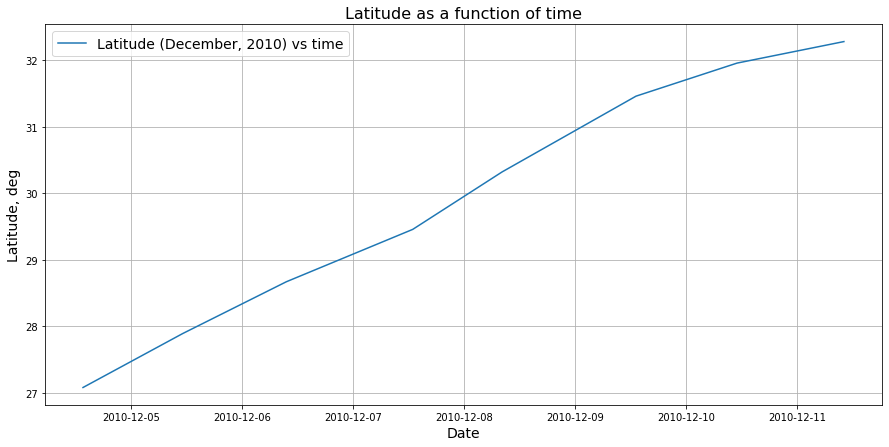

In [ ]:
# Now let us plot the dependence of the latitude on time
fig = plt.figure(figsize=(15, 7))
plt.plot(dates, lat, label = 'Latitude (December, 2010) vs time')
plt.title('Latitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

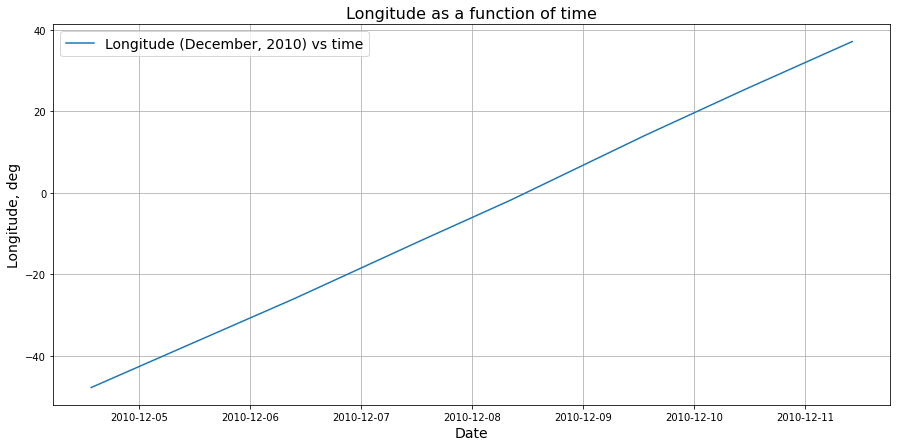

In [ ]:
# Let us plot the dependence of the longitude on time
fig = plt.figure(figsize=(15, 7))
plt.plot(dates, lon, label = 'Longitude (December, 2010) vs time')
plt.title('Longitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Longitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

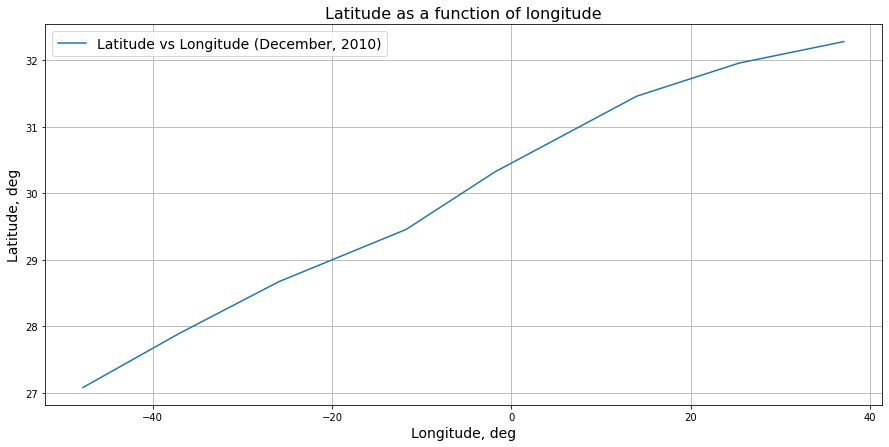

In [ ]:
# Let us plot the dependence of the latitude on the longitude
fig = plt.figure(figsize=(15, 7))
plt.plot(lon, lat, label = 'Latitude vs Longitude (December, 2010)')
plt.title('Latitude as a function of longitude', fontsize=16)
plt.xlabel('Longitude, deg', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

In [ ]:
corr, _ = pearsonr(lon, lat)
print('Pearsons correlation coefficient: %.3f' % corr)

Pearsons correlation coefficient: 0.995


**From these three graphs above, one may notice that the dependencies of both latitude and longitude on time are quite close to linear. Thus, the rotation rates related to the change of both latitude and longitude on time are more or less constant. Moreover, it results in the fact that the values of latitude and longitude are correlated - it can be seen from the Pearsons correlation coefficient which is quite close to 1.**

In [ ]:
# We determine the angular velocity of solar rotation per day using the obtained longitude and taking into account the time between images. 
# The result corresponds to the synodic angular velocity

omega_synod = []

for i in range(len(dates) - 1):
  delta = dates[i + 1] - dates[i]
  days = delta.days + delta.seconds / 60 / 60 / 24
  omega_synod.append((lon[i + 1] -  lon[i]) / days) # deg / day

In [ ]:
# Now we determine the sidereal rotation rate

# Earth orbital period around the Sun:
p_earth = 365.2564 # days

omega_sid10 = []

for i in range(len(dates) - 1):
    p_synod = 360 / omega_synod[i] # days

    # siderial rotation period, days
    p_sid = p_earth * p_synod / (p_earth + p_synod) # days
    # siderial rotation rate
    omega_sid = 360 / p_sid # deg / day

    omega_sid10.append(omega_sid)

In [ ]:
# Finally, we determine the functional form of solar differential rotation obtained from statistical studies:
a = 14.55 # deg / day
b = -2.87 # deg / day

lat_array = np.linspace(-50, 50, 100)
omega_sid_theory = a + b * np.sin(lat_array*np.pi/180) ** 2

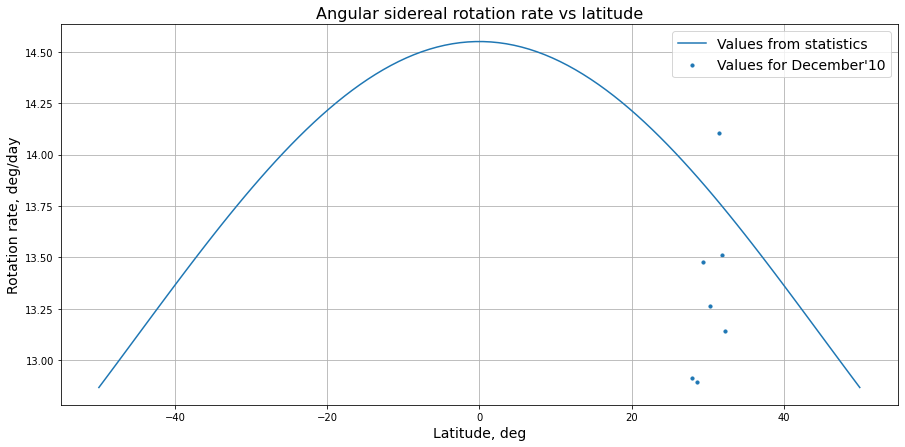

In [ ]:
# And here we plot both the dependency of the latitude values obtained from the dataset and the dependency known from statistical studies
fig = plt.figure(figsize=(15, 7))
plt.scatter(lat[1:], omega_sid10, label='Values for December\'10', s = 10)
plt.plot(lat_array, omega_sid_theory, label='Values from statistics')
plt.title('Angular sidereal rotation rate vs latitude', fontsize=16)
plt.xlabel('Latitude, deg', fontsize=14)
plt.ylabel('Rotation rate, deg/day', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

**As a result, we see that the scatter plot of the latitude values which were obtained during the dataset's processing shows errors in comparison with the given curve from statistics. However, the data scattering lies within 1.5 deg per day which is a valid result if we recall the original statistics curve (it reveals that the higher the module of the latitude value, the bigger the error). The errors may have appeared at the stage where we estimated roughly the center of mass of the spot we track.**

# **JUNE, 2016 | DATA PROCESSING**

**Here we use absolutely the same approach to determine the dates and the coordinates of the spot for this dataset. However, it shall be noticed that we did not use two pictures from the dataset [June, 10 and June, 22] since it was not possible to identify the sunspot under study.**

In [ ]:
uploaded_sum = files.upload()

In [ ]:
# These two images will not be involved in data processing since the stop under study cannot be observed here
data_1, header_1 = sunpy.io.fits.read('kanz_bband_fd_20160610_1042.fts')[0]
data_1 = ndimage.rotate(data_1, header_1['SOLAR_P0'], reshape=False)
map_1 = sunpy.map.Map(data_1, header_1)

data_2, header_2 = sunpy.io.fits.read('kanz_bband_fd_20160622_0809.fts')[0]
data_2 = ndimage.rotate(data_2, header_2['SOLAR_P0'], reshape=False)
map_2 = sunpy.map.Map(data_2, header_2)

/usr/local/lib/python3.7/dist-packages/sunpy/util/decorators.py:378: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.

  new_val = prop(instance)


Observatory,KPT
Instrument,KPDC
Detector,TM4200-5
Measurement,5460.0 ANG
Wavelength,5460.0 ANG
Observation Date,2016-06-10 10:42:07
Exposure Time,0.002423 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.0224 1.0224] arcsec / pix
Reference Pixel,[1023.5 1023.5] pix

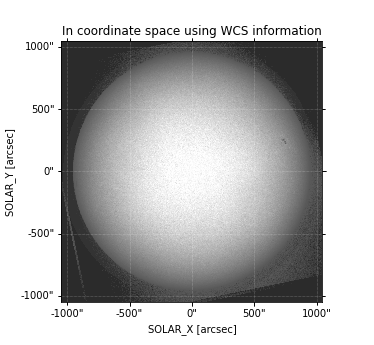
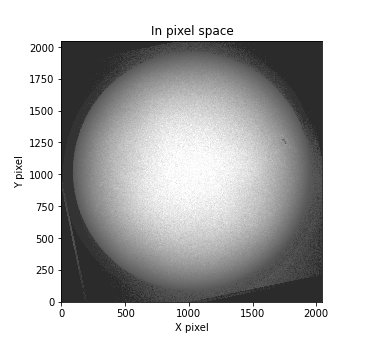
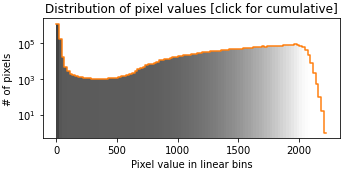
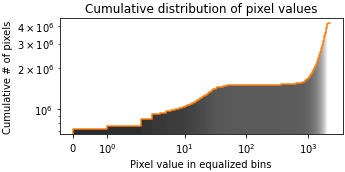

In [ ]:
# The image from June, 10th
map_1

/usr/local/lib/python3.7/dist-packages/sunpy/util/decorators.py:378: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.

  new_val = prop(instance)


Observatory,KPT
Instrument,KPDC
Detector,TM4200-5
Measurement,5460.0 ANG
Wavelength,5460.0 ANG
Observation Date,2016-06-22 08:09:55
Exposure Time,0.002392 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.02152 1.02152] arcsec / pix
Reference Pixel,[1023.5 1023.5] pix

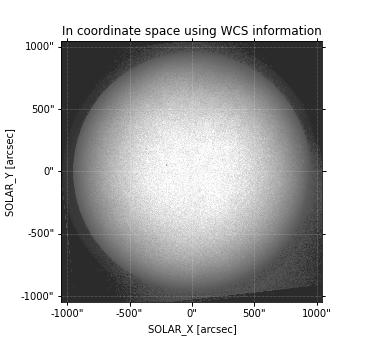
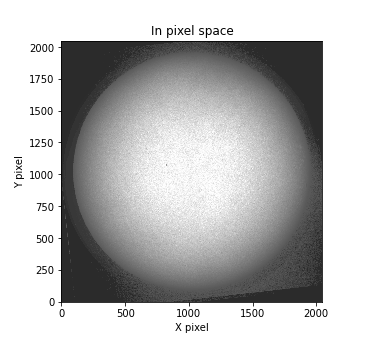
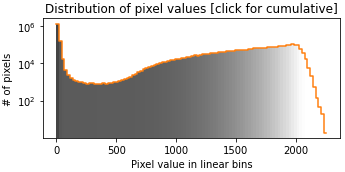
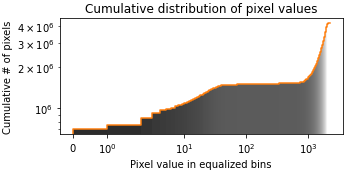

In [ ]:
# The image from June, 22
map_2

In [ ]:
# Therefore, only these files will be used:
data_list_sum = ['kanz_bband_fd_20160610_1042.fts',
              'kanz_bband_fd_20160612_0942.fts',
              'kanz_bband_fd_20160613_0632.fts',
              'kanz_bband_fd_20160614_1113.fts',
              'kanz_bband_fd_20160615_0729.fts',
              'kanz_bband_fd_20160616_0739.fts',
              'kanz_bband_fd_20160617_0613.fts',
              'kanz_bband_fd_20160618_0559.fts',
              'kanz_bband_fd_20160619_0731.fts',
              'kanz_bband_fd_20160621_0629.fts']

In [ ]:
SPOT_X_16 = []
SPOT_Y_16 = []
SPOT_Z_16 = []
lat_16 = []
lon_16 = []
dates_16 = []

for i in range (len(data_list_sum)):
  data, header = sunpy.io.fits.read(data_list_sum[i])[0]
  data = ndimage.rotate(data, header['SOLAR_P0'], reshape=False)
  map = sunpy.map.Map(data, header)
  dates_16.append(pd.to_datetime(header['DATE-OBS'], format='%Y-%m-%dT%H:%M:%S'))

  for k in range (0, 2048):
    for j in range (0, 2048):
      if (data[k][j]) > 1100 or (data[k][j] < 400):
        data[k][j] = 800
      else:
        data[k][j] = 0

  contours = map.contour(100)

  n = []

  for k in range(len(contours)):
    if  60 < len(contours[k]) < 160:
      n.append(k)

  len_spot = np.array([149, 155, 91, 75, 91, 99, 99, 93, 83, 65])

  for k in range(len(n)):
    if len(contours[n[k]]) == len_spot[i]:
      center = int(len(contours[n[k]])/2)
      SPOT_Y_16.append(contours[n[k]][center].Tx / contours[n[k]][center].Tx.unit / 1.02274)
      SPOT_Z_16.append(contours[n[k]][center].Ty / contours[n[k]][center].Ty.unit / 1.02274)
      SPOT_X_16.append((header['SOLAR_R'] ** 2 - SPOT_Y_16[i] ** 2 - SPOT_Z_16[i] ** 2) ** 0.5)
      theta = (np.arccos(SPOT_Z_16[i] / header['SOLAR_R']) * 180 / np.pi) / u.rad
      lat_16.append(float(90 - theta))
      lon_16.append(math.atan2(SPOT_Y_16[i], SPOT_X_16[i]) * 180 / np.pi)

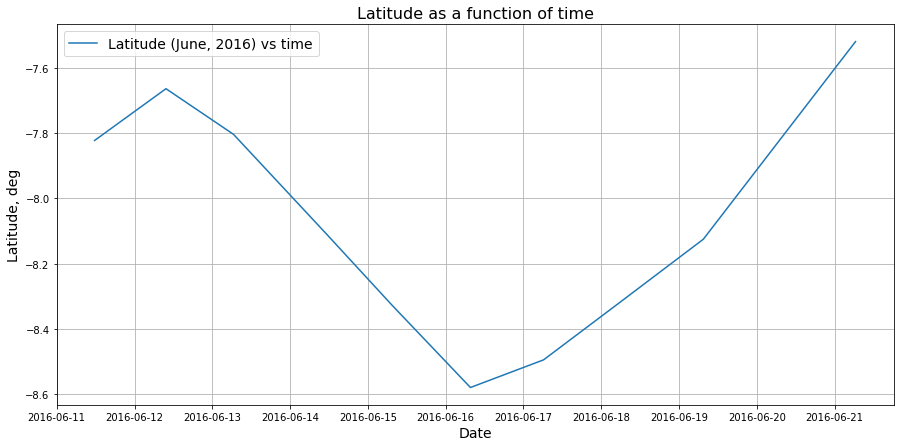

In [ ]:
# Now let us plot the dependence of the latitude on time
fig = plt.figure(figsize=(15, 7))
plt.plot(dates_16, lat_16, label = 'Latitude (June, 2016) vs time')
plt.title('Latitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

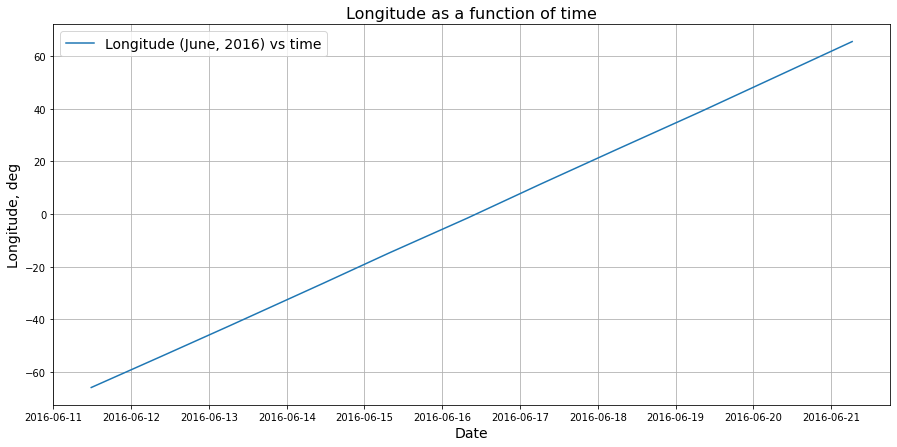

In [ ]:
# Now let us plot the dependence of the longitude on time
fig = plt.figure(figsize=(15, 7))
plt.plot(dates_16, lon_16, label = 'Longitude (June, 2016) vs time')
plt.title('Longitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Longitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

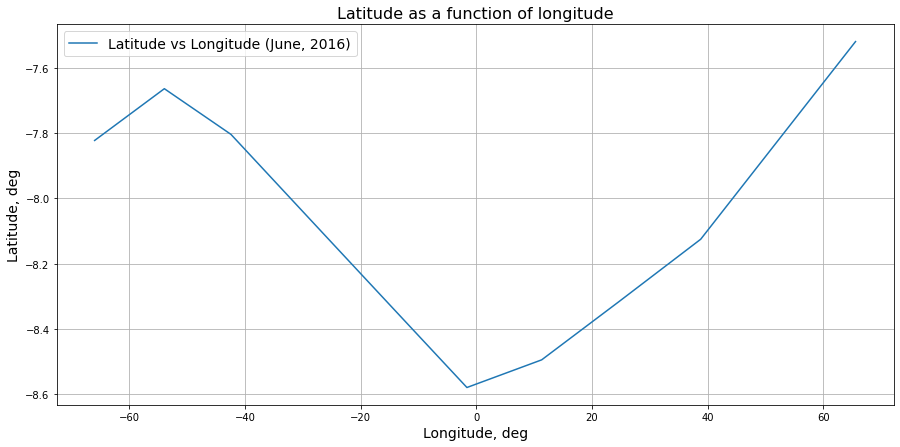

In [ ]:
# Let us plot the dependence of the latitude on the longitude
fig = plt.figure(figsize=(15, 7))
plt.plot(lon_16, lat_16, label = 'Latitude vs Longitude (June, 2016)')
plt.title('Latitude as a function of longitude', fontsize=16)
plt.xlabel('Longitude, deg', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

**Here we may see a completely different behaviour of the functions: the latitude changes in a non-linear way in comparison with the previous winter case where we considered sunspot at high latitudes and we saw a linear dependency, while the longitude on time function remains linear as it was before. As a result, there is no correlation of latitudes and longitudes in this case.**

In [ ]:
omega_synod_16 = []

for i in range(len(dates_16) - 1):
  delta = dates_16[i + 1] - dates_16[i]
  days = delta.days + delta.seconds / 60 / 60 / 24
  omega_synod_16.append((lon_16[i + 1] -  lon_16[i]) / days) # deg / day

In [ ]:
omega_sid_16 = []

for i in range(len(dates_16) - 1):
    p_synod = 360 / omega_synod_16[i] # days

    # siderial rotation period, days
    p_sid = p_earth * p_synod / (p_earth + p_synod) # days
    # siderial rotation rate
    omega_sid = 360 / p_sid # deg / day

    omega_sid_16.append(omega_sid)

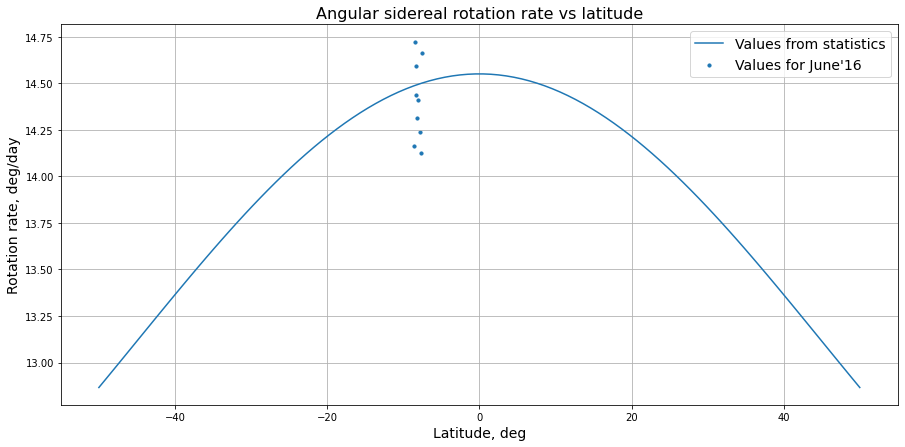

In [ ]:
# And here we plot both the dependency of the latitude values obtained from the dataset and the dependency known from statistical studies
fig = plt.figure(figsize=(15, 7))
plt.scatter(lat_16[1:], omega_sid_16, label='Values for June\'16', s = 10)
plt.plot(lat_array, omega_sid_theory, label='Values from statistics')
plt.title('Angular sidereal rotation rate vs latitude', fontsize=16)
plt.xlabel('Latitude, deg', fontsize=14)
plt.ylabel('Rotation rate, deg/day', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

**On this graph, we notice that the data scattering from the calculated values from statistical studies is less significant in this case (less than 0.5 degree on average) which was also seen on the original graph presented on the lecture. However, even there we used rough estimations of the spot's center of mass which may have led to the errors.**

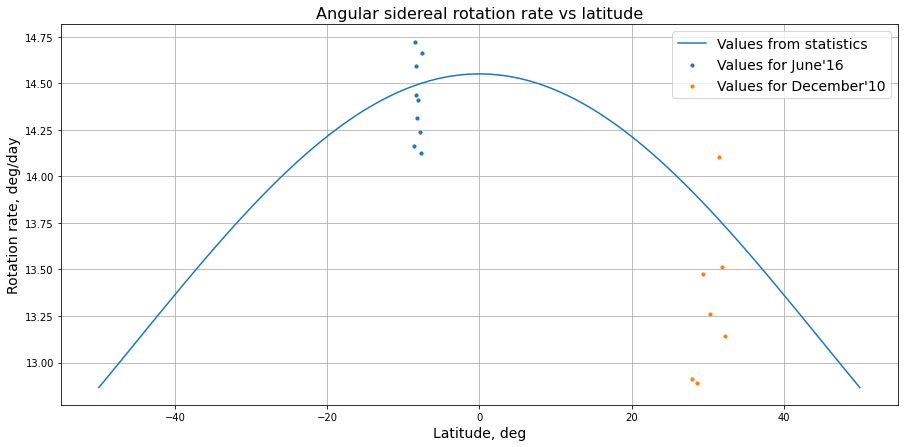

In [ ]:
# Now we are interested to see both plots together
fig = plt.figure(figsize=(15, 7))
plt.scatter(lat_16[1:], omega_sid_16, label='Values for June\'16', s= 10)
plt.scatter(lat[1:], omega_sid10, label='Values for December\'10', s= 10)
plt.plot(lat_array, omega_sid_theory, label='Values from statistics')
plt.title('Angular sidereal rotation rate vs latitude', fontsize=16)
plt.xlabel('Latitude, deg', fontsize=14)
plt.ylabel('Rotation rate, deg/day', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

**As a result, we see that the rotation rate obtained from the dataset with a near-equator sunspot is on average 0.50-0.75 degree higher than for the value from the dataset with high latitude sunspot. The dispersion of the points is quite high due to several rought estimations made within the assignment's implementation.**

**Learning log**  
During the assignment's implementation, we became familiar with FITS-format and content of its data and header sections. In order to process the data, we used  such libraries as *astropy* and *sunpy* that are widely applied to data processing in solar studies. Firstly, we learnt how to detect a sunspot on the image: we implemented a code which set thresholds to pixel values to go to binary scale; then, we used a function *contours* which found all the closed contours on the image and, based on the estimated length of these contours, we found the contour which corresponds to the sunspot. Afterwards, the location of the sunspot was identified in both XYZ coordinates as well as lon/lat. Using these values of the coordinates, we managed to obtain sidereal and synodic rotation rates of the sun.  
It was noticed that there is a significant distinction in sunspots' movement near equator and closer to pole - the rotation rate is higher at near-equator regions than at high-latitude areas - but in both cases our results corresponded to the statistically-based models of Sun. This model includes two coefficient: ***a*** corresponds to the rotation rate of the sunspot which is located directly at equator (since it is the case of lat = 0 and the sinus of 0 is 0); ***b*** represents latitudinal gradient of the rotation. Difference in angular sidereal rotation rate confirms the model of Sun as not-solid gaseous ball and, as it was expected, the equator rotates faster than poles. 